# Imports

In [50]:
import pandas as pd 
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data Loading and Cleaning for Analysis

In [51]:
df=pd.read_csv("blocstak_data.csv")

There are **4521** datapoints in this dataset. The dataset is highly imbalanced with **y**'s ratio of unique values being **0.88: 0.12**

In [52]:
print(f"LENGTH OF DATASET: {len(df)}")
print((df.y.value_counts()/len(df)))


LENGTH OF DATASET: 4521
y
no     0.88476
yes    0.11524
Name: count, dtype: float64


In [53]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [54]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


From the data, some forms of cleaning that seem necessary are:
- The **day** column isnt quite necessary due to the monthly information being readily available.
- The **month** column would be better utilized within a ordinal form of values instead of plain strings.
- The **duration** column needs to be normalized to minutes from seconds due to scale of durations. 
- The **y** variables are better of renamed to **result** for analysis. We can keep a seperate **y** column for binary values.

In [55]:
# Drop days
df.drop(columns=['day'],inplace=True)
# Normalize duration from aseco0nds to minutes
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
# Add binarized column
df['result']=df['y'].copy()
df['y'] = df['y'].apply(lambda x: 0 if x == 'no' else 1)
# Create dictionary of months to map to ordinal values
month_list=list(enumerate(calendar.month_name))[1:]
month_dict={key.lower()[:3]:value for value,key in month_list}
# Map month strings to ordinal values
df['month']=df.month.apply(lambda x:month_dict[x])


# Exploratory Data Analysis & Visualization

## Distribution of Continuous Variables within Dataset

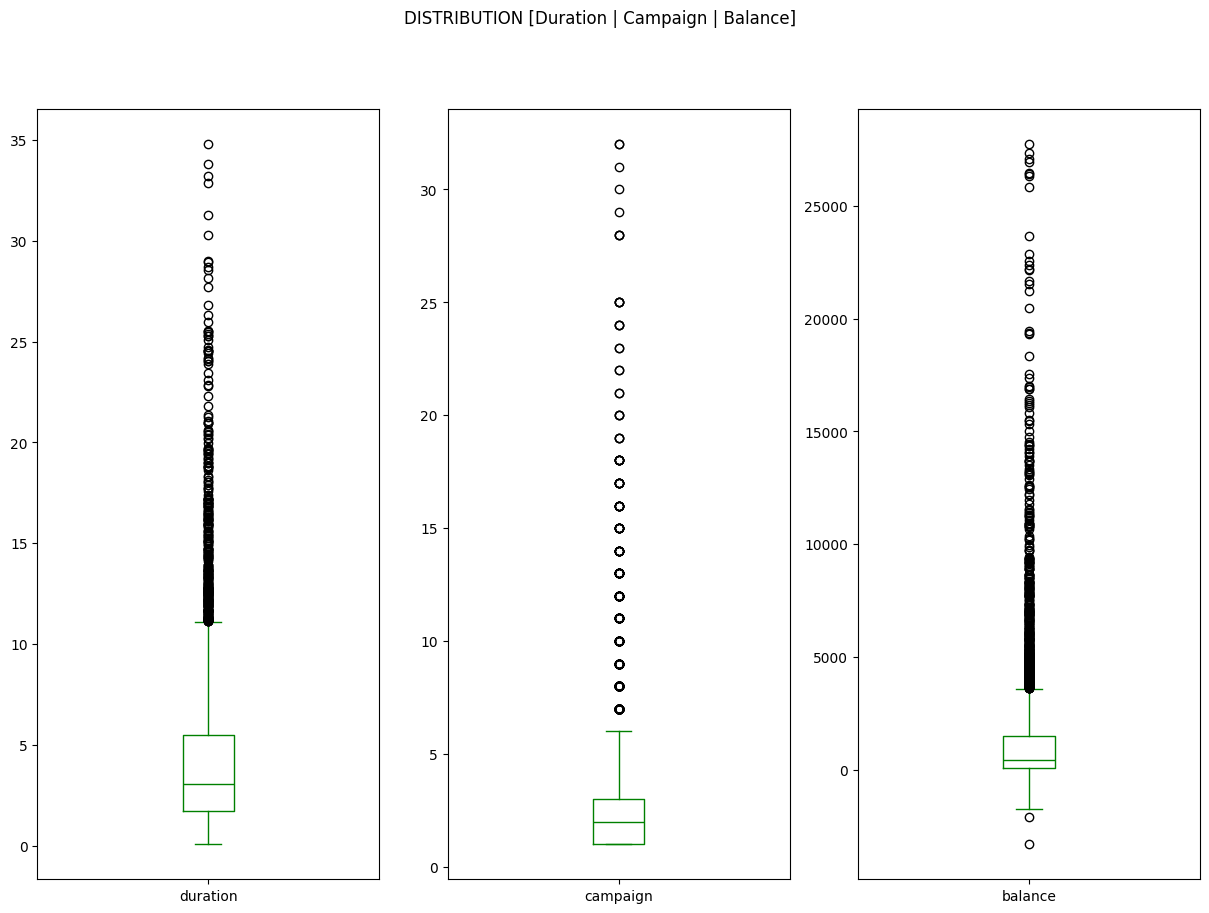

,min,std,mean,median,outlier_count,Q1,Q3,IQR,<1.5*IQR,>1.5*IQR
duration,0.07,4.198564,4.373908,3.08,327.0,1.73,5.48,3.75,-3.895,11.105
campaign,1.00,2.968849,2.774701,2.00,316.0,1.00,3.00,2.00,-2.000,6.000
balance,-3313.00,2761.399401,1398.929774,444.50,504.0,69.00,1477.00,1408.00,-2043.000,3589.000


In [115]:
def get_q_dict(column:pd.Series):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return {'Q1':Q1,'Q3':Q3,'IQR':IQR}


def outlier_count(column:pd.Series):
    qdict=get_q_dict(column)
    Q1,Q3,IQR=qdict['Q1'],qdict['Q3'],qdict['IQR']
    threshold = 1.5
    outliers = (column < Q1 - threshold * IQR) | (column > Q3 + threshold * IQR)
    return outliers.sum()


#Aggregating data for "Duration", "Campaign", "Balance" columns in the dataset
durcampbal=df[['duration','campaign','balance']].agg(func=['min','std','mean','median',outlier_count],axis='rows').T
q_dict_list=[get_q_dict(df[col]) for col in durcampbal.index]
durcampbal['Q1']=[i['Q1'] for i in q_dict_list]
durcampbal['Q3']=[i['Q3'] for i in q_dict_list]
durcampbal['IQR']=[i['IQR'] for i in q_dict_list]
durcampbal['<1.5*IQR']=durcampbal['Q1']-1.5*durcampbal['IQR']
durcampbal['>1.5*IQR']=durcampbal['Q3']+1.5*durcampbal['IQR']

#Visualizing boxplots and outliers based on observed data
duration_distance_plot = df[['duration','campaign','balance']].plot(kind = 'box', color= 'green',
                                                      figsize = (15,10),
                                                      subplots = True, layout = (1,3),
                                                      sharex = False, sharey = False,
                                                      title='DISTRIBUTION [Duration | Campaign | Balance]')
plt.show()

durcampbal

- **Distribution of Duration**: Observations from table and boxplot indicates the duration of contact had a median of 3 minutes, along with a first quartile of 1.73 minutes with a third quartile of 5.3 minutes spanning a 3.7 minute Inter Quartile Range. The relative left skew in the distribution shows that most calls were on the shorter end with considerable amount of outliers ranging from 11 to 40 minutes. These outliers seem to be key in hunting for marketing leads.
- **Distribution of Campaign**: 25% of the customers were contacted by the bank for the first time, while approximately half of them were contacted for the second time. Most clients were contacted only thrice, however there is a even distribution of outlieres ranging from 5 times to approximately 33 times along with a select few ranging to be as high as 45 to 50 times.
- **Distribution of Balance**: Balance seems to show the highest amount of outliers and is the most left skewed of the three distributions we have seens so far, with values even extending to negatives ranging of considerable magnitude. (Funnily enough, this also goes to represent how the rich keep eating the poor hehe). The standard deviation and high interquartile range represents the high population of outliers as seen in the boxplot. Also, it can be seen that there is probably just a single or two outliers in the 40 thousands' range.
- The extreme outliers on all three distributions need to be dropped for better probabilistic modelling.

In [57]:
extreme_outlier_rows=df[(df.duration>40)|(df.balance>30000)|(df.campaign>40)]
df.drop(extreme_outlier_rows.index,inplace=True)

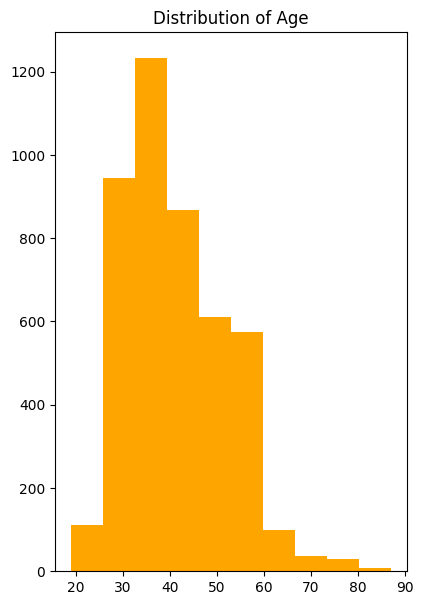

Age details: 
count    4514.000000
mean       41.161276
std        10.575681
min        19.000000
25%        33.000000
50%        39.000000
75%        49.000000
max        87.000000
Name: age, dtype: float64


In [116]:
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.hist(df.age,color='orange')
plt.title("Distribution of Age")
plt.show()
print(f"Age details: \n{df['age'].describe()}")


- **Distribution of Age**: Majority of clients contacted by bank seem of in their 30s or 40s (The interquartile range of percentiles range from 33 to 48 year olds). Other than this, the distribution is fairly normal.

In [59]:
df['age_buck']=pd.cut(df.age,bins=[df.age.min(),30,40,50,60,df.age.max()],labels=["=<30","30-40","40-50","50-60",">=60"],right=True)

## Feature Correlations

Text(0.5, 1.0, 'Feature Correlation Heatmap')

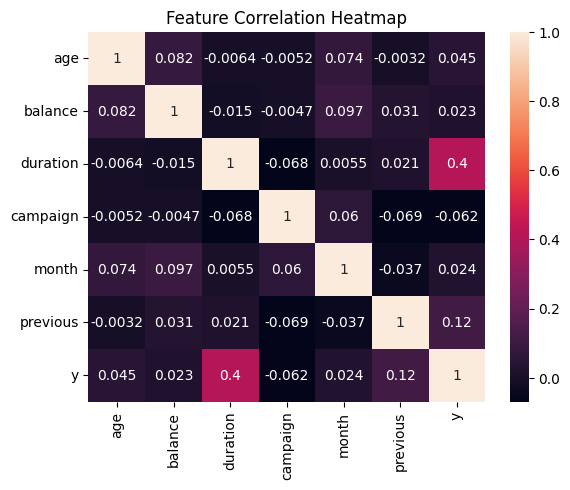

In [61]:

feature_correlation= df[['age','balance','duration','campaign','month','previous','y']].corr()
corr_map=sns.heatmap(feature_correlation,annot=True,)
plt.title('Feature Correlation Heatmap')

- In order for more indepth analysis we need to look at how each of our dataset features correlate with all the other features. As we can see in our correlationmap, there is strong correlation among **marketting result**, **call duration** and **Campaign**. This goes to show that marketting success is highly dependant on customer interactions. 
- We can also see considerable correlation between **marketting result** and **age** and between **age** and **balance**. 
- Most of the higher values of correlation with marketting results pertain to dataset features that relate to customer characterisitcs (E.g: **age**, **balance**, **duration**,). Thus it would be beneficial to look at aggregate cluster based results on categorical customer based features inorder for more insight. 

## Relationship between Different Features and Age Groups

One of the basic and most prominent customer characteristic feature in our dataset is **Age**. Let us visualize customer sensitivity of each age group to our marketting campaigns. **(Conversion/Interaction Rate)**

### 1. Balance
As observed in correlation map, there is strong correlation between:
- **age** and **conversion**. 
- **balance** and **age**. 

This goes to show that binning our **balances** to certain levels may show some insights between age_group sensitivity towards marketting campaign when paired with pertaining balances of age groups.

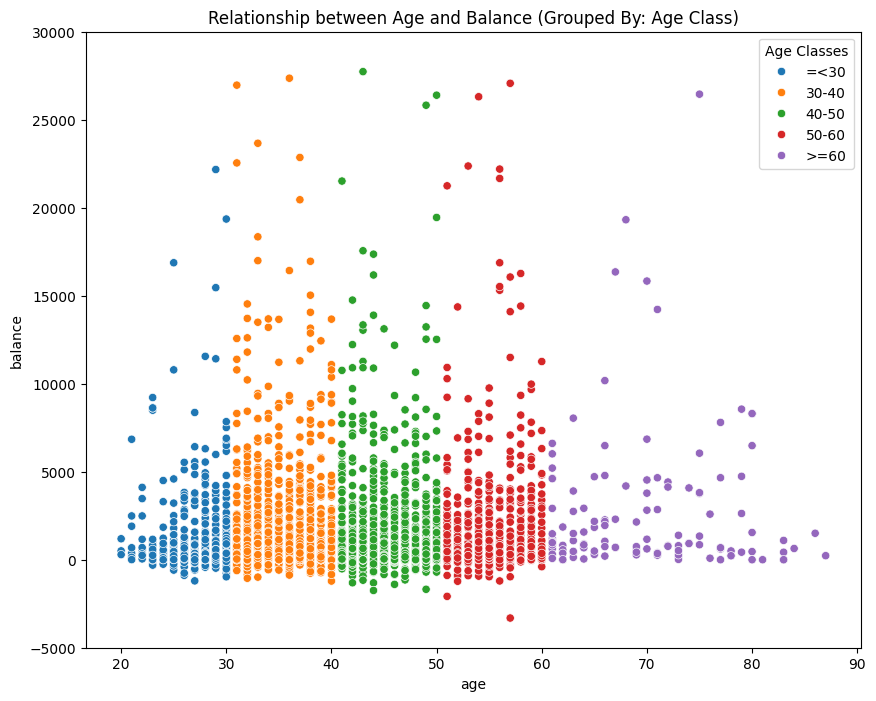

In [60]:
import numpy as np
#Capping our balance to a max of 30000 for extreme outliers
plt.figure(figsize=(10,8))
plt.ylim(-5000,30000)
sns.scatterplot(x='age',y='balance',data=df,hue='age_buck')
plt.title('Relationship between Age and Balance (Grouped By: Age Class)')
plt.legend(title='Age Classes')




- From the above diagram, it is safe to conclude that there isnt any notable direct relationship between **Age** and **Balance** of customers in terms of specific age groups. 
- Perhaps this is due to the variability in values and maybe aggregate information on different ranges of **Age** and **Balance** might provide better insight on **Conversion Rates**. This shall be investigated on below.
- Also, it can be noted that people at 60 and above tend to have lesser balance than younger people, also, people at after 60, tend to have very low negative balances. This could be due to planned funding of expenses that people make due to retirement.

C:\Users\noorr\AppData\Local\Temp\ipykernel_13064\2225472556.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  balance_group1.loc[(balance_group1.age_buck==age),'y']=(balance_group1[balance_group1.age_buck==age].y/int(age_interaction[age_interaction.age_buck==age].Contacted))*100
C:\Users\noorr\AppData\Local\Temp\ipykernel_13064\2225472556.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'y':float((age_interaction[age_interaction['age_buck']==age].Contacted/age_interaction.Contacted.sum())*100)


Text(0.5, 1.0, 'Conversion based on Different Age and Balance Groups')

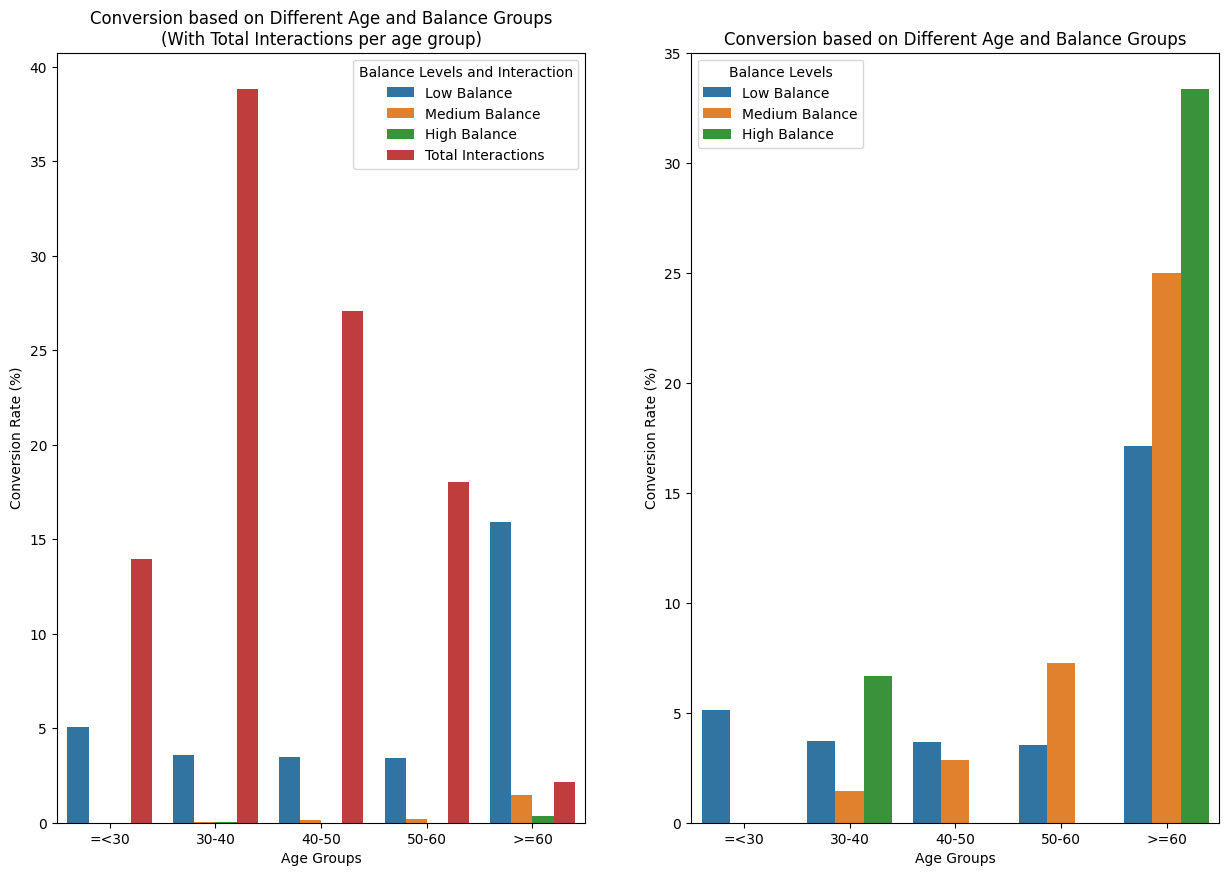

In [63]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['balance_buck']=pd.cut(df.balance,bins=3,labels=['Low Balance','Medium Balance','High Balance'])
balance_group=(df.groupby(['age_buck','balance_buck'],as_index=False).y.sum())
balance_group['Contacted']=df.groupby(['age_buck','balance_buck'],as_index=False).campaign.sum().campaign  
balance_group1=balance_group.copy(deep=True)
balance_group1.pop('Contacted')    
age_interaction=balance_group.groupby('age_buck',as_index=False).Contacted.sum() 
interactions_df=pd.DataFrame([])
for age in age_interaction.age_buck.unique():
    balance_group1.loc[(balance_group1.age_buck==age),'y']=(balance_group1[balance_group1.age_buck==age].y/int(age_interaction[age_interaction.age_buck==age].Contacted))*100
    new_entry=pd.DataFrame({
        'age_buck':age,
        'balance_buck':'Total Interactions',
        'y':float((age_interaction[age_interaction['age_buck']==age].Contacted/age_interaction.Contacted.sum())*100)
    },index=[0])
    interactions_df=pd.concat([interactions_df,new_entry],ignore_index=True)
balance_group1=pd.concat([balance_group1,interactions_df],ignore_index=True)
balance_group1.sort_values('age_buck')

sns.barplot(x='age_buck',y='y',hue='balance_buck',data=balance_group1)
plt.legend(title='Balance Levels and Interaction')
plt.xlabel("Age Groups")
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion based on Different Age and Balance Groups\n(With Total Interactions per age group)")

plt.subplot(1,2,2)
df['balance_buck']=pd.cut(df.balance,bins=3,labels=('Low Balance','Medium Balance','High Balance'))
balance_group=df.balance_buck.value_counts()
balance_group=(df.groupby(['age_buck','balance_buck'],as_index=False).y.sum())
balance_group['Contacted']=df.groupby(['age_buck','balance_buck'],as_index=False).campaign.sum().campaign
age_interaction=balance_group.groupby('age_buck',as_index=False).Contacted.sum()    


balance_group.y=(balance_group.y/balance_group['Contacted'])*100
balance_group.sort_values(['age_buck','balance_buck'],ascending=[True,False],inplace=True)
sns.barplot(x='age_buck',y='y',hue='balance_buck',data=balance_group)
plt.legend(title='Balance Levels')
plt.xlabel("Age Groups")
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion based on Different Age and Balance Groups")

**Insight:**
- From the above figures we can see that the **youngest** and **oldest age groups** show the highest responsiveness to marketting campaigns given the **Total Number of Interactions per group**
- It can also be noted that all **Age Groups** with **lower levels of balances** tended to be more responsiveness to marketting campaigns as compared to **Age Groups** of **other balances**
- **Age Groups** of *'30-40'* tend to be more responsive towards marketting campaign when **Balance Level** is high. This pertains to the reducing lack of knowledge in investment of growing funds/capital as consumers grow in their respective careers.
- In **Age Groups** of *'40-50'* and *'50-60'*, higher comparitive responsiveness of **Balance Level** moved from *'Low'* to *'High'* as compared to other  **balance levels** because the consumers are slowly becoming more aware of different forms of short sized investments with age and development in career, thus people with lower levels of **Balance** at the age of *'50-60'* shift towards other forms of investments as compared to people with lower levels of **Balance** at the age of *'40-50'*.

### 2. Interactions (Campaign)
Customer Interactions paired with customers of different demographies (**Age Groups**) provides quite deep insights on which demographies to focus on for better campaign success. Let us look into the Conversion and Interaction Rates for customers of different **Age Groups**

,count,Converted,Interacted
age_buck,,,
=<30,628,14.01,13.92
30-40,1798,9.84,39.87
40-50,1159,10.53,25.70
50-60,798,10.28,17.69
>=60,127,37.80,2.82


<Figure size 900x900 with 0 Axes>

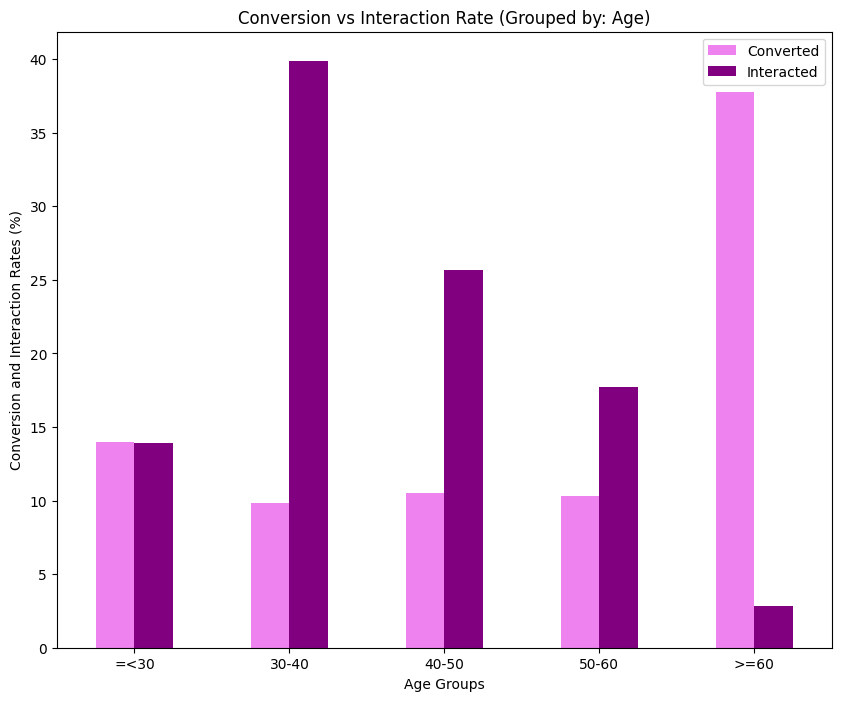

In [118]:
age = pd.DataFrame(df['age_buck'].value_counts())

result_age_group=df.groupby(['age_buck','result']).result.count()
subscription_idx=[i for i  in result_age_group.index.tolist() if i[1]=='yes']


age.sort_index(inplace=True)
age['Converted']=((result_age_group[subscription_idx].to_numpy()/age['count'])*100).round(2)
age['Interacted']=((age['count']/age['count'].sum())*100).round(2)
plt.figure(figsize=(9,9))
age[['Converted','Interacted']].plot(kind='bar',figsize=(10,8),color=('violet','purple'))

plt.xlabel("Age Groups")
plt.ylabel('Conversion and Interaction Rates (%)')
plt.xticks(rotation='horizontal')
plt.title('Conversion vs Interaction Rate (Grouped by: Age)')
age

**Insight: Wrong age groups are being focused on for marketting deposit based schemes. Focus should be more on the youngest and oldest age groups**\
\
From the above chart we can clearly see that age groups within the range of '*30-60*' years of age, are much less sensitive to marketting efforts by bank as compared to those younger than 30 years of age and those older than 60 years of age.
- It seems that old people are most sensitive to deposit based marketting efforts by bank due to probable availability of wealth accumulated through out the years. 
- Younger people's attraction to monthly interests on deposits seems to stem from the lack of proper knowledge on investment schemes and may seem as a lucrative option for liquidity to the age group in general. The sensitivity of younger age groups towards marketting interactions thus show that there might be **occupational dependencies** on a customer's preference of marketting campaigns due age being a general indicator of a person's position in his or her career. 

## Call Duration & Campaign
- The highest correlation in our correlation matrix for **y**  was with **duration** which inturn, had the highest correlation with **campaign**.
- As in most campaigns,one of the key factors to determine marketting success is **conversion rate** compared to **interactions**. So let us look at the relationship among **Conversions**,  **Call Duration of Last Telemarketting Call** by bank to customer and the **Number of times the customer was interacted with**. 

Text(20, 45, 'Greater Conversion rate when no. of calls <5')

<Figure size 800x1500 with 0 Axes>

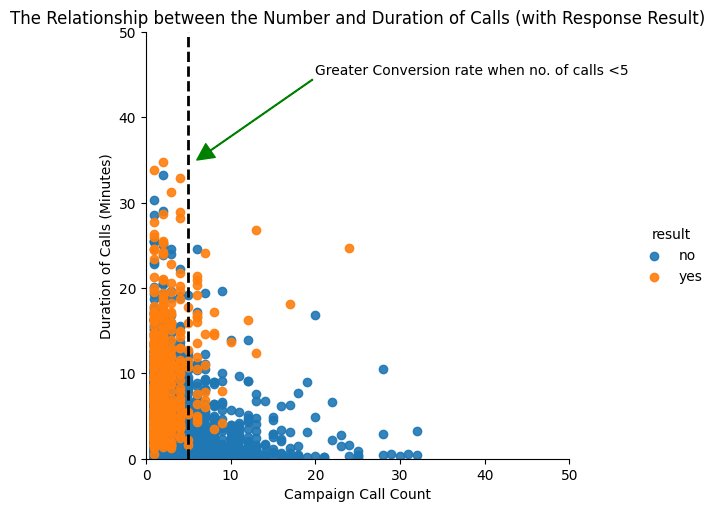

In [87]:
plt.figure(figsize=(8,15))
sns.lmplot(x='campaign',y='duration',data=df,hue='result',fit_reg=False,height=5,scatter_kws={'alpha':0.9})

plt.axis([0,50,0,50])
plt.ylabel('Duration of Calls (Minutes)')
plt.xlabel('Campaign Call Count')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')


plt.axvline(x=5, linewidth=2, color="black", linestyle='--')
plt.annotate("Greater Conversion rate when no. of calls <5", xytext=(20,45), arrowprops=dict(color='green',width=0.5),xy=(6,35))

**Insight: Telemarketeers must be trained to make more engaging, informative and helpful conversations and try to make sure leads are converted within the fifth call**

According to this scatter plot, the datapoints form two clusters in which most datapoints with larger number of contact instances tend to have coversations of lower durations that usually ends up with negative client response. Whereas, most positive responses tend to come from clients who have been contacted fewer times, but have had long, engaging converstions each time he or she was contacted. Clients seem to be more likely to reject the deposit scheme unless conversation is long and engaging or number of times contacted is less than 5.
This suggests that banks should refrain from calling a client more than 5 times as well as making telemarketting conversations more engaging.

## Job

Another very important customer characteristic to consider that we didnt keep in the correlation matrix is the **Job** characteristic, a person's job highly influences one's decision to choose bank deposit schemes as different jobs offer different levels of periodic wealth accumulation. Let us look at Conversion and Interaction rates based on **Job Positions**.

Text(0.5, 1.0, 'Job Position Sensitivity towards Marketting Campaign')

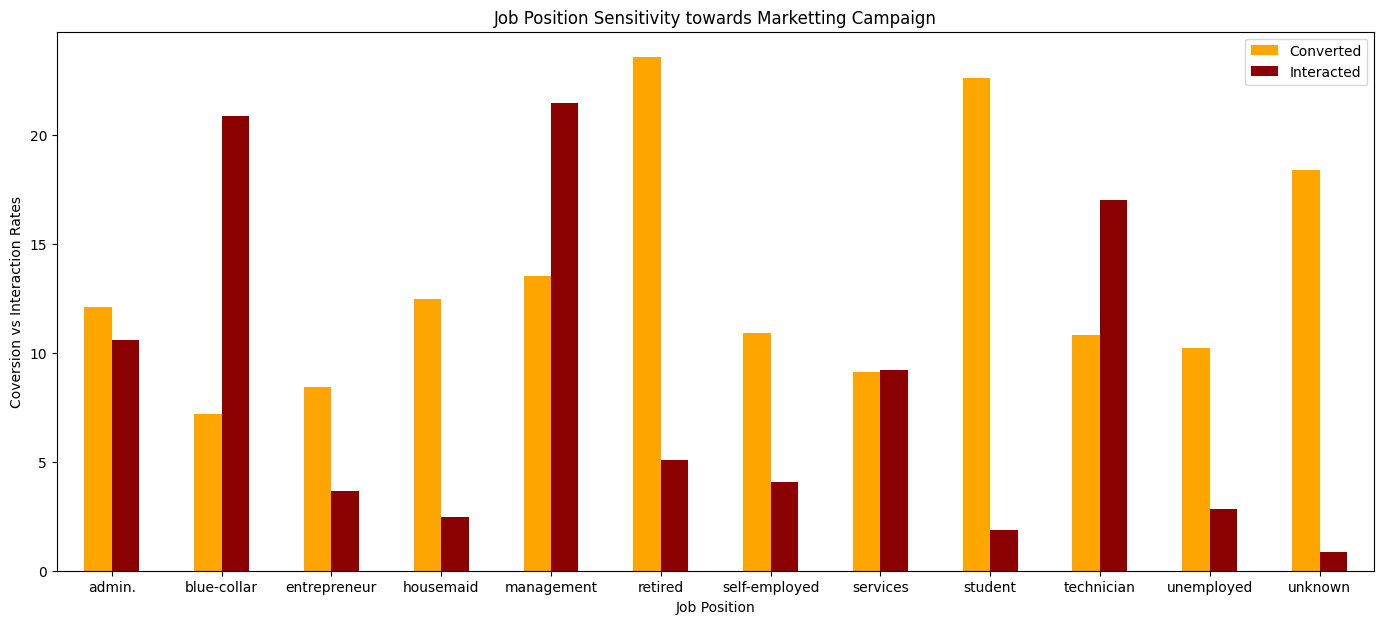

In [113]:
job=pd.DataFrame(df.groupby('job').job.count())
job['Converted']=(df.groupby(['job']).y.sum()/job['job'])*100
job["Interacted"]=(job["job"]/job['job'].sum())*100

job[['Converted','Interacted']].plot(kind='bar',figsize=(17,7),color=('orange','darkred'))
plt.xticks(rotation='horizontal')
plt.ylabel('Coversion vs Interaction Rates')
plt.xlabel('Job Position')
plt.title('Job Position Sensitivity towards Marketting Campaign')

**Insight: Customers from the wrong job classes are being focused on by campaign**
- As inferred from our previous Age based Conversion Diagrams, there is high dependency between **Customer Conversion Rates** and **Job Positions**, and the bank is focusing on customers from ther wrong job positions.
- For example: **Job Positions** like **management**, **blue-collar** and **technician** are all getting comparitively higher focus from marketting campaign than the other job positions even 
though all the others seem to be more positively sensitive towards the campaign. The most suprising factor among which is that **students** and **maids** seem to be the remarkably sensitive towards marketting campaigns. Thus our campaigns and services should be tailored in a way to take advantage of this in forms of **micro investment/deposit instruments** and their promotions.
- The postive sensitivity of retired people towards deposit schemes is natural given the accumulation of wealth through life. 

## Seasonal Factors

Another very important categorical feature to focus on when looking at Conversion Trends is the chronological feature of Conversions. This will provide insight on which months to do telemarketting campaigns the most. Let us look at our Conversion and Interaction Rates based on months:

Text(0.5, 1.0, 'Monthly Conversion and Interaction Trends')

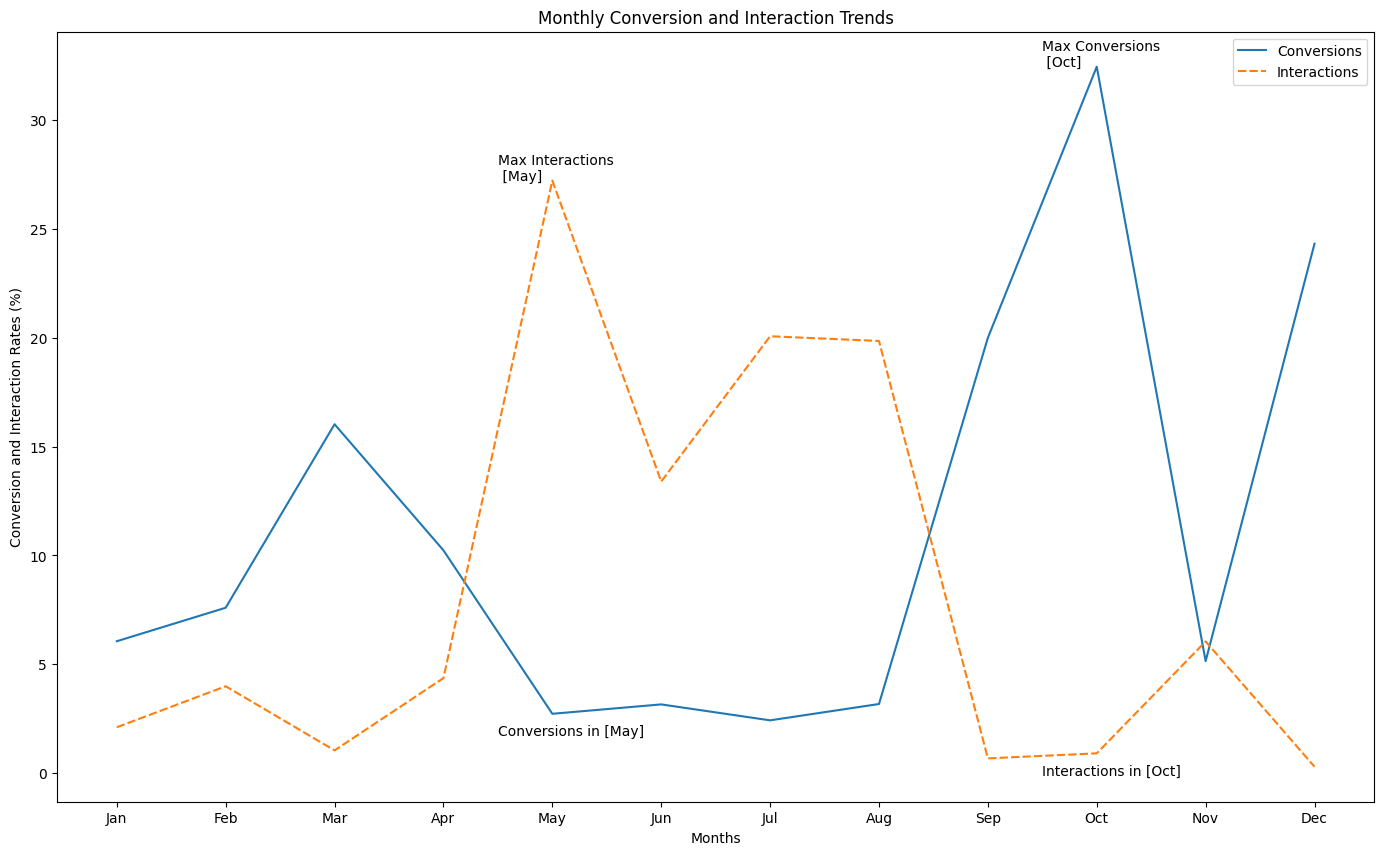

In [178]:
monthly_conversion_group=df.groupby(['month','result'],as_index=False).y.sum()
monthly_conversion_group=monthly_conversion_group[monthly_conversion_group.y>0].drop(columns='result').set_index('month').rename({'y':'Conversions'},axis=1)
monthly_conversion_group['Interactions']=df.groupby(['month']).campaign.sum()
monthly_conversion_group['Conversions']=monthly_conversion_group['Conversions']*100/monthly_conversion_group['Interactions']
monthly_conversion_group['Interactions']=monthly_conversion_group['Interactions']*100/monthly_conversion_group['Interactions'].sum()
plt.figure(figsize=(17,10))
plt.xticks(ticks=range(1,13),labels=[i.capitalize() for i in month_dict.keys()])
sns.lineplot(monthly_conversion_group)
high_y=monthly_conversion_group['Conversions'].max()
high_x=monthly_conversion_group['Conversions'].idxmax()
interaction_when_high_y=monthly_conversion_group['Interactions'][x]

high_int=monthly_conversion_group['Interactions'].max()
high_intx=monthly_conversion_group['Interactions'].idxmax()
conv_when_high_int=monthly_conversion_group['Conversions'][high_intx]

plt.annotate(f"Max Conversions\n [{(list(month_dict.keys())[high_x-1]).capitalize()}]",xy=(high_x-0.5,high_y))
plt.annotate(f"Interactions in [{(list(month_dict.keys())[high_x-1]).capitalize()}]",xy=(high_x-0.5,interaction_when_high_y-1))

plt.annotate(f"Max Interactions\n [{(list(month_dict.keys())[high_intx-1]).capitalize()}]",xy=(high_intx-0.5,high_int))
plt.annotate(f"Conversions in [{(list(month_dict.keys())[high_intx-1]).capitalize()}]",xy=(high_intx-0.5,conv_when_high_int-1))


plt.xlabel("Months")
plt.ylabel('Conversion and Interaction Rates (%)')
plt.title('Monthly Conversion and Interaction Trends')

**Insights: Campaigns have been focused on most, on months in which conversion rates were lowest, and focused least on, on months in which conversion trends were steepest.** 
- Conversion Trends seem to start rising during Fall Season and peak at November. During which, ironically, the campaign Interaction Rates are the lowest. The trends of the two lines follow opposite courses in this manner throughout the whole year. This goes to show how wrong the bank's timing was in focusing on telemarketting campaigns.
- Conversion Rate is comparitively high in the beginning of the year as compared to the rest of months till September, probably residual effect from previous year's peaking Fall trends.
- Bank should initiate telemarketting campaigns during start of Fall Season and span the duration till the end of Spring for optimal conversion/interaction rate.

# Machine Learning


In [532]:
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.base import BaseEstimator,TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB,GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,LabelBinarizer

## Data Loading & Cleaning

In [654]:
data=pd.read_csv('blocstak_data.csv')

In [655]:
print(f"UNKNOWN VALUES IN ROWS: {(data=='unknown').sum(1).value_counts()}")
print("************************************************************")
print("************************************************************")
print(f"UNKNOWN VALUES IN COLS: {(data=='unknown').sum(0)}")

UNKNOWN VALUES IN ROWS: 1    2350
2    1322
0     764
3      80
4       5
Name: count, dtype: int64
************************************************************
************************************************************
UNKNOWN VALUES IN COLS: age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64


- Dataset doesnt seem to have too many row-wise unknown values. 
- **Contact** and **Poutcome** seem to be the only ones with high unknown values, they should be dropped
- Unknown values on **job** and **education** can either be imputed or dropped row-wise due to small amount of samples. 

In [656]:
data.drop(columns=['poutcome','contact'],inplace=True)
print(f"UNKNOWN VALUES IN COLS AFTER:\n {(data=='unknown').sum(0)}")

UNKNOWN VALUES IN COLS AFTER:
 age            0
job           38
marital        0
education    187
default        0
balance        0
housing        0
loan           0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
y              0
dtype: int64


In [657]:
# Distribution of target variables in rows with 'unknown' values 
print(data.loc[((data=='unknown').sum(1)>0),'y'].value_counts()/data.y.value_counts())
drop_idx=data[(data=='unknown').sum(1)>0].index.to_list()
data.drop(drop_idx,axis=0,inplace=True)


y
no     0.046750
yes    0.044146
Name: count, dtype: float64


- The ratio of data rows with unknown variables seem to be very low and equally distributed for both 'yes' and 'no' based on population target values.
- Dropping these rows of data, would not have any significant impact on my models

## Feature Engineering
Now that we have cleaned our data, we need to select and engineer our features for training the model.
Features related most towards customer characterstics should be chosen. Such features within the dataset includes:
- Age
- Job
- Marital Status
- Education
- Housing
- Balance
- Loan
- Default
- Duration
- Campaign (Number of times Contacted)
- Previous (Number of times Contacted)


In [658]:
data['y_bin']=LabelEncoder().fit_transform(data['y'])
X=data[['age','job','marital','education','housing','balance','loan','default','duration','campaign','previous']]
y=data['y_bin']


A problem that we might face when implementing Naive Bayes is that **Balance** of customers can be negative. So the best way to go about this is to scale all our **Balance** values with sigmoid function. Since sigmoid is always in positive scale, this wont affect our data as all other data will be normalized to a scale similar to ranges between 0 and 1 

In [659]:
# def sigmoid(x):
#     return 1/(1 + np.exp(-x))


# X['balance']=sigmoid(X['balance'])

In [660]:
y.value_counts()

y_bin
0    3813
1     498
Name: count, dtype: int64

As we can see, our data consists of very high imbalance (1:7) ratio. Therefore, we need to add a combination of sampling strategies to our model.

## Preprocessor for different datatypes

In [661]:
from sklearn.preprocessing import MinMaxScaler
class YesNoBinarize(BaseEstimator,TransformerMixin):
    def __init__(self, keys):
        self.keys=keys
        
    def fit(self, X,y=None):
        self.X_=X.copy()
        return self
    
    def transform(self, X,y=None):
        for key in self.keys:
            if key in self.X_:
                self.X_[key]=self.X_[key].apply(lambda x:1 if x=='yes' else 0)    
            else:
                continue
        return self.X_



numeric_features = ["age",'duration','campaign','previous','balance']                         # not adding balance as it is already scaled
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_features = ["education", "job"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),]
)

binary_features = ['default','loan','housing',]
binary_transformer = Pipeline(
    steps=[
        ("encoder",YesNoBinarize(binary_features))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features),
    ]
)

In [662]:
X_processed=preprocessor.fit_transform(X,y)

In [663]:
train_x,test_x,train_y,test_y=train_test_split(X_processed,y)

## Samplers

Now that our data has been preprocessed and split, we need to fix the imbalance in our dataset as discussed above. The best way to go about this, is to randomly undersample overpopulated data, while oversampling our minority data with **ADASYN** whilst making sure our real life ratio of data is similar to that of our resampled data.

In [681]:
rand_undersamp=RandomUnderSampler(random_state=88,sampling_strategy=1/7)
adasyn=ADASYN(random_state=88,sampling_strategy=2/7)
smote=SMOTE(random_state=88,sampling_strategy=2.8/6)

X_up,y_up=rand_undersamp.fit_resample(train_x,train_y)
print(y_up.value_counts())
X_ada,y_ada=adasyn.fit_resample(X_up,y_up)
print(y_ada.value_counts())
x_samp,y_samp=smote.fit_resample(X_ada,y_ada)
print(y_samp.value_counts())

y_bin
0    2674
1     382
Name: count, dtype: int64
y_bin
0    2674
1     742
Name: count, dtype: int64
y_bin
0    2674
1    1247
Name: count, dtype: int64


In [685]:
tree = DecisionTreeClassifier(random_state=88)
tree_grid = {
        'splitter': ['best','random'],
        'min_samples_split':[2,3,6,10,12,],
        'criterion' :['gini', 'entropy','log_loss'],
        'min_samples_leaf':[2,3,6],
        'max_leaf_nodes':[2,3,4,5,6]        
        }
tree_grid_cv = GridSearchCV(tree, tree_grid, scoring = 'accuracy', cv = 7)
tree_grid_cv.fit(x_samp,y_samp)
print(f"Grid Validated Accuracy of Tree Model with best params: {tree_grid_cv.best_score_}")
best_tree=tree_grid_cv.best_estimator_

Grid Validated Accuracy of Tree Model with best params: 0.8084793008112335


In [688]:
nb=ComplementNB()
nb_grid={
    'alpha':np.linspace(1,50,10)
    }
nb_grid_cv = GridSearchCV(nb, nb_grid, scoring = 'accuracy', cv = 7)
nb_grid_cv.fit(x_samp,y_samp)
print(f"Grid Validated Accuracy of Naive Bayes Model with best params: {nb_grid_cv.best_score_}")
best_nb=nb_grid_cv.best_estimator_

Grid Validated Accuracy of Naive Bayes Model with best params: 0.629422678162174


In [689]:
from sklearn.metrics import  balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

y_pred=best_tree.predict(test_x)

roc=roc_auc_score(test_y, y_pred)
bal_acc = balanced_accuracy_score(test_y, y_pred)
prec = precision_score(test_y, y_pred)
rec = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
print(f"TREE VALIDATION SCORES:\n ROC Score:{roc}\n Balanced Accuracy: {bal_acc}\n Precision: {prec}\n Recall: {rec} \n F1 Score: {f1}")


print("\n*************************************************************\n")

y_pred=best_nb.predict(test_x)

roc=roc_auc_score(test_y, y_pred)
bal_acc = balanced_accuracy_score(test_y, y_pred)
prec = precision_score(test_y, y_pred)
rec = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
print(f"NAIVE BAYES VALIDATION SCORES:\n ROC Score:{roc}\n Balanced Accuracy: {bal_acc}\n Precision: {prec}\n Recall: {rec} \n F1 Score: {f1}")


TREE VALIDATION SCORES:
 ROC Score:0.7833446842067531
 Balanced Accuracy: 0.7833446842067532
 Precision: 0.41798941798941797
 Recall: 0.6810344827586207 
 F1 Score: 0.5180327868852459

*************************************************************

NAIVE BAYES VALIDATION SCORES:
 ROC Score:0.631550648792028
 Balanced Accuracy: 0.6315506487920282
 Precision: 0.17307692307692307
 Recall: 0.6206896551724138 
 F1 Score: 0.27067669172932335


Given our validation metrics, we can safely assume that our Tree model performed much better than our Naive Bayes model.
**Model Agnostic Metric Characteristics**
- If we look at the metrics, we can see that our Precision score is comparitively lower in both our models, this may be attributed to our resampling. When we resampled, we tried to scale down our "no" responses while scaling up our 'yes' responses due to high imbalance.
    - This scaling however, was done only on training set, whereas the distribution of data remained the same as before scaling in our test splits.
    - Due to being very high number of 'no' response in testing split, as compared to our training split, our model was biased towards predicting false positives.
    - **ROC Scores**, **Balanced Accuracy** as well as **Recall**, all have higher scores for both the models because resampling of data has brought about more class balance, thus our models are not being biased by majority classes
**Inter-Model Metric Characteristics**
- When comparing both our models we can clearly see that most scores are higher for our Decision Tree.
- **ROC Scores** and **Balanced Accuracy** are both much higher for our Decision Tree than our Naive Bayes. This is probably due to the higher complexity in probability calculations done by Tree based Models as compared to Naive Bayes Models.
- The **Naive Bayes model** has much worse Precision scores than our **Decision Tree**. This means that our **Naive Bayes Model** is more prone to predicting false positives compared to the **Decision Tree**.
- **Precisions** of both the models are similar, whilst the Naive Bayes's score being smaller by 0.06, this shows that our Naive Bayes is also more prone to predicting **false negatives** as compared to our **Decision Tree**
- The F1 